In [1]:
import os
import pickle
import random
import matplotlib.pyplot  as plt
import numpy  as np
import time
import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from gru_dataloader import GruDataLoader, collate

Using backend: pytorch


In [2]:
import math
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return  '%dm %ds' % (m, s)

In [3]:
# # A4ZPX2
# tied1_name_l = ['Q5G5V8','Q5G5V4','Q6EG58','A4ZPW4','P04578','Q4QXE8','A8CVW4','Q2MKA8','A1EAH8','A1EAI4','Q27Q69','Q70014','B2YFU9','B2YFQ5','O89960']
# # A1EAI3
# tied2_name_l = ['Q5G5U7','Q5G5U5','A7KVY7','Q5G5V1','B0FBI6','Q5G5V5','A1EAI2','A1EAI0','Q6TCV7','Q202K1','Q202K7','Q27Q74','A1EAI7','B2YFT0','Q8JDI3']
# # A4ZPW9
# tied3_name_l = ['A4ZPX1','A4ZPW7','A4ZPW8','Q5G5V2','Q5G5U6','A1EAG8','A1EAH7','A0MTL0','A1EAH6','A1EAH3','B2YFP6','B2YFP1','B2YFU4','B2YFV4','B2YFS0']
# tied_name=tied1_name_l+tied2_name_l+tied3_name_l

In [4]:
def read_data(paths):
    f=open(paths,"r")
    seq_dict={}
    for line in f:
        if line.startswith('>'):
                name=line.replace('>','').split()[0]
                seq_dict[name]=''
        else:
                seq_dict[name]+=line.replace('\n','').strip()
    f.close()
    return seq_dict

In [5]:
#datapath
path1='/home/dldx/UniRep/datatmp/gp120_45/tier_1.fasta'
path2='/home/dldx/UniRep/datatmp/gp120_45/tier_2.fasta'
path3='/home/dldx/UniRep/datatmp/gp120_45/tier_3.fasta'

path=[path1,path2,path3]

In [6]:
seqs_=[]
type_=[]
seqs_dict={}
for i in range(3):
    seq_dict=read_data(path[i])
    seqs_dict.update(seq_dict)
    seq=list(seq_dict.values())
    seqs_+=seq
    type_+=[i]*len(seq)

In [7]:
seqs_train=seqs_
type_train=type_

In [8]:
print(len(seqs_train),len(type_train))

45 45


In [9]:
class NameDataset(Dataset):
    def __init__(self,  is_train_set= True):
        if is_train_set:
            seqs = seqs_train    
            types=type_train
        else : 
            seqs = seqs_test    
            types=type_test
                
        self.x_data = seqs
        self.y_data = types

        self.len = len(self.x_data)
        
        self.seqs_dict = seqs_dict
        self.type_num = len(self.y_data)
    
    def __getitem__(self, index):
        #self.x_data[index], self.y_data[index]
        #print('调用__getitem__')
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len


In [10]:
from sklearn.preprocessing import label_binarize
index=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
global acid_dict
acid_dict={}
for i in range(len(index)):
    acid_dict[index[i]]=i

def seq2list(seq):
    '''输入：seq，为一条氨基酸序列。'''
    seq_=[]
    for s in range(0,len(seq)):
        seq_.append(acid_dict[seq[i]])
    seq_tt=label_binarize(seq_, classes=range(0,20))  
    #print(type(seq_tt),seq_tt)
    arr = [ord(c)  for c  in seq]
    return seq_tt, len(arr)

In [11]:
def make_tensors(seqs, types):
    sequences_and_lengths = [seq2list(seq)  for seq  in seqs]
    name_sequences = [sl[0]  for sl  in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1]  for sl  in sequences_and_lengths])
    types = types.long()
    
    # make tensor of name, BatchSize x SeqLen——>paddding
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max(),20)
    #print(len(seq_tensor[0]),type(seq_tensor[0]),seq_tensor[0].size(),seq_tensor[0])
    
    for idx, (seq, seq_len)  in enumerate(zip(name_sequences, seq_lengths), 0):
        #print('idx:',idx)
        #print(seq,seq_len)
        #x=torch.LongTensor(seq)
       # print(x,type(x),x.size())
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
        
    # sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending= True)
    seq_tensor = seq_tensor[perm_idx]
    types = types[perm_idx]
    
    return create_tensor(seq_tensor), \
            create_tensor(seq_lengths),\
            create_tensor(types)

In [12]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers,attention_size, bidirectional= True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.layer_size=n_layers
        self.n_directions = 2  if bidirectional  else 1
        self.embedding = torch.nn.Linear(input_size, hidden_size)
        
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers,
                                bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)#torch.Size([64, 3])
        

        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions,
                             batch_size, self.hidden_size)
        return create_tensor(hidden)
    
    
    def forward(self, input, seq_lengths):
        # input shape : B x S -> S x B
        #input = input.t()
        input = input.permute(1,0,2)
#         print(input.shape)
#         print(input.dtype)
        batch_size = input.size(1)
        hidden = self._init_hidden(batch_size)
        embedding = self.embedding(input)
        #embedding = input
        # pack them up
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths)
        output, hidden = self.gru(gru_input, hidden)
        #print(output[0].shape)
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        #print(hidden_cat.shape)

        fc_output = self.fc(hidden_cat)
        return fc_output

In [13]:
def trainModel(classifier,train_loader):
    total_loss = 0
    correct = 0
    total = 0
    for i, (seqs, types)  in enumerate(train_loader, 1):
        #print(types)
        inputs, seq_lengths, target = make_tensors(seqs, types)
        #print('seq_lengths',seq_lengths)
        output = classifier(inputs, seq_lengths)
        #print("inputs:",inputs.size())
        #print("output:",output.size())

        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total+=len(target)
        pred = output.max(dim=1, keepdim= True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    percent =  '%.2f' % (100 * correct / total)
    
    total_loss += loss.item()
#     if 0 == 0:
#         print( f'loss={total_loss / (i *  len (inputs))}')
    return total_loss,percent

In [14]:
def testModel(classifier,train_loader):
    classifier.eval()
    correct = 0
    total = 0
    targets,outputs=[],[]
    #print( "evaluating trained model ...")
    with torch.no_grad():
        for i, (seqs, types)  in enumerate(train_loader, 1):
            inputs, seq_lengths, target = make_tensors(seqs, types)

            output = classifier(inputs, seq_lengths)

            pred = output.max(dim=1, keepdim= True)[1]
            total+=len(target)

            correct += pred.eq(target.view_as(pred)).sum().item()
            targets.append(target)
            outputs.append(output)
        percent =  '%.2f' % (100 * correct / total)
#         print( f'Test set: Accuracy {correct}/{total} {percent}%')
    classifier.train()
    
    return correct / total,outputs,targets

In [15]:
# Parameters
HIDDEN_SIZE = 32
BATCH_SIZE = 15
N_LAYER = 2
N_EPOCHS =100
N_CHARS = 20
USE_GPU =  True
OUT_SIZE=3
Attention_size=16

In [16]:
# set up seeds, args.seed supported
seed=2021
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)

#指定GPU
torch.cuda.set_device(3)
if torch.cuda.is_available():

    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed=seed)
else:
    device = torch.device("cpu")
print(device)

cuda


In [17]:
def create_tensor(tensor):
    if USE_GPU:
        device = torch.device( "cuda")
        tensor = tensor.to(device)
    return tensor

In [19]:
dataset=NameDataset(is_train_set= True)
if USE_GPU:
    device = torch.device( "cuda")

train_l,test_l=[],[]
datalist=[]
draw_train=[]
start = time.time()
for fold_idx in range(10):
    
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, OUT_SIZE , N_LAYER,Attention_size).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    train_loader,valid_loader = GruDataLoader(dataset, batch_size=16, device=device,
                                                collate_fn=collate, seed=2021, shuffle=True,
                                                split_name='fold10', fold_idx=fold_idx).train_valid_loader()
    train_loss,draw_acc=[],[]
    valid_acc_tmp=0
    for epoch  in range(1, N_EPOCHS + 1):
        # Train cycle
    
        los,_=trainModel(classifier,train_loader)

        valid_acc,outputs,targets = testModel(classifier,valid_loader)
        draw_acc.append(valid_acc)
        train_loss.append(los)
        if valid_acc > valid_acc_tmp:
            valid_acc_tmp=valid_acc   
    datalist.append([valid_acc_tmp,targets,outputs])
    draw_train.append([train_loss,draw_acc])
    print("第{}折完成,验证集准确率为{}".format(fold_idx,valid_acc_tmp)) 

loss_acc='gru_acc_10fold_45.p'
with open(loss_acc, 'wb') as f:
    pickle.dump(datalist, f)
end = time.time()
print("运行时间:%.2f秒"%(end-start))      
print("work down!")

train_set : test_set = 40 : 5
第0折完成,验证集准确率为0.6
train_set : test_set = 40 : 5
第1折完成,验证集准确率为0.4
train_set : test_set = 40 : 5
第2折完成,验证集准确率为0.6
train_set : test_set = 40 : 5
第3折完成,验证集准确率为0.4
train_set : test_set = 40 : 5
第4折完成,验证集准确率为0.8
train_set : test_set = 41 : 4
第5折完成,验证集准确率为0.5
train_set : test_set = 41 : 4
第6折完成,验证集准确率为0.75
train_set : test_set = 41 : 4
第7折完成,验证集准确率为0.5
train_set : test_set = 41 : 4
第8折完成,验证集准确率为0.5
train_set : test_set = 41 : 4
第9折完成,验证集准确率为0.5
运行时间:724.86秒
work down!


In [20]:

all_info=datalist

acc=[]
for i in range(10):
    
    acc.append(all_info[i][0])
print(np.mean(acc))

0.5549999999999999


In [21]:
np.std(acc)

0.12737739202856996

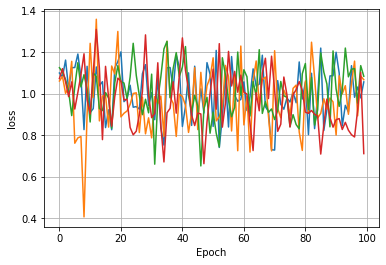

In [28]:
for i in range(4):
    plt.plot(draw_train[i][0])

plt.xlabel( 'Epoch')
plt.ylabel( 'loss')
plt.grid()
plt.show()

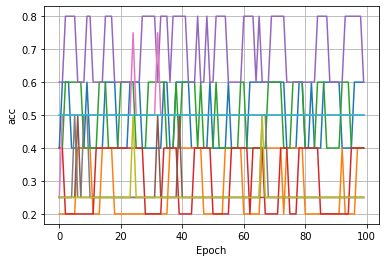

In [23]:
for i in range(10):
    plt.plot(draw_train[i][1])

plt.xlabel( 'Epoch')
plt.ylabel( 'acc')
plt.grid()
plt.show()

In [ ]:
all_info[0][2]

In [ ]:
score

In [ ]:
label

In [ ]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
all_rocauc=[]
AP=[]
for k in range(10):
    
    score=(all_info[k][2][0].cpu().numpy())
    label=(all_info[k][1][0].cpu().numpy())
    label=label_binarize(label, classes=[0, 1, 2])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test,y_score=label,score
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(roc_auc["micro"])
    all_rocauc.append(roc_auc["micro"])
    #=========================================
    Y_test,y_score=y_test,y_score
    n_classes=3
# For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
    AP.append(average_precision["micro"])
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))
print(np.mean(AP),np.std(AP))

In [ ]:
np.mean([0.6,0.3,0.56,0.24,0.4,0.75,0.84375,0.125,0.34375,0.625])

In [ ]:
np.std(all_rocauc)

In [ ]:
print(np.mean(AP),np.std(AP))

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='aqua',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc[2])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('ROC_all.png',format='png',dpi=300)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

Y_test,y_score=y_test,y_score
n_classes=3
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
#plt.savefig('Average precision score.png',format='png',dpi=300)

In [ ]:
#Recording the accuracy of testing.
for i in range(10):
    acc_list=train_l[i]
    epoch = np.arange(1, len(acc_list) + 1, 1)
    acc_list = np.array(acc_list)
    plt.plot(epoch, acc_list)
plt.xlabel( 'Epoch')
plt.ylabel( 'Accuracy')
plt.grid()
plt.show()

In [ ]:
#Recording the accuracy of testing.
acc_max=[]
for i in range(10):
    acc_list=test_l[i]
    acc_max.append(max(acc_list))

    epoch = np.arange(1, len(acc_list) + 1, 1)
    acc_list = np.array(acc_list)
    plt.plot(epoch, acc_list)
plt.xlabel( 'Epoch')
plt.ylabel( 'Accuracy')
plt.grid()
plt.show()
print(np.mean(acc_max))

In [ ]:
for i, (seqs, types)  in enumerate(train_loader, 1):
    inputs, seq_lengths, target = make_tensors(seqs, types)


In [ ]:
def test_Model(classifier):
    classifier.eval()
    correct = 0
    total = 0
    print( "evaluating trained model ...")
    with torch.no_grad():
        for i, (seqs, types)  in enumerate(valid_loader, 1):
            inputs, seq_lengths, target = make_tensors(seqs, types)

            output = classifier(inputs, seq_lengths)

            pred = output.max(dim=1, keepdim= True)[1]
            print(target)
            total+=len(target)
            
            correct += pred.eq(target.view_as(pred)).sum().item()
        percent =  '%.2f' % (100 * correct / total)
        print( f'Test set: Accuracy {correct}/{total} {percent}%')
    classifier.train()
    
    return correct / total
test_Model(classifier)

In [ ]:
#Recording the accuracy of testing.
epoch = np.arange(1, len(losses) + 1, 1)
loss = np.array(losses)
plt.plot(epoch, loss)
plt.xlabel( 'Epoch')
plt.ylabel( 'loss')
plt.grid()
plt.show()

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
clf = DummyClassifier()

scores = cross_val_score(clf, inputs.cpu(), target.cpu())
scores
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
print(evalModel(classifier))

In [ ]:
with open('qq.txt','r') as f:
    dd=f.read()

In [ ]:
ii=list(dd.split())

In [ ]:
print(ii)